In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))


/tmp/ipykernel_2785/945712042.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import os
import argparse
from typing import Any, Callable, Sequence
from pathlib import Path
from PIL import Image
import matplotlib.image as mpimg

import jax
import jax.random as jr
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.flatten_util import ravel_pytree
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn


from bong.util import run_rebayes_algorithm, gaussian_kl_div, MLP
from bong.src import bbb, blr, bog, bong, experiment_utils
#from bong.agents import AGENT_NAMES




Matplotlib created a temporary cache directory at /tmp/matplotlib-2u3li7yr because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2024-05-24 18:15:47.309401: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [16]:
key = jr.PRNGKey(0)
print(key)

[0 0]


In [14]:
parser = argparse.ArgumentParser()

# Data parameters
if 1:
    parser.add_argument("--dataset", type=str, default="sarcos") 
    parser.add_argument("--data_dim", type=int, default=0)
    parser.add_argument("--dgp_type", type=str, default="na") # or mlp
    parser.add_argument("--dgp_str", type=str, default="na") # 20_20_1 
    #parser.add_argument("--ntrain", type=int, default=0)
    parser.add_argument("--ntrain", type=int, default=100)
    parser.add_argument("--nval", type=int, default=0)
    parser.add_argument("--ntest", type=int, default=0)
    parser.add_argument("--init_var", type=float, default=1000) # unregularized
else:
    parser.add_argument("--dataset", type=str, default="reg") 
    parser.add_argument("--data_dim", type=int, default=10)
    parser.add_argument("--dgp_type", type=str, default="lin") 
    parser.add_argument("--dgp_str", type=str, default="20_20_1") 
    parser.add_argument("--ntrain", type=int, default=100)
    parser.add_argument("--nval", type=int, default=100)
    parser.add_argument("--ntest", type=int, default=100)
    parser.add_argument("--init_var", type=float, default=1000)

parser.add_argument("--emission_noise", type=float, default=-1)
parser.add_argument("--linreg_baseline", type=int, default=1)


# Model parameters
#parser.add_argument("--agent", type=str, default="bong_fc", choices=AGENT_NAMES)
parser.add_argument("--algo", type=str, default="bong")
parser.add_argument("--param", type=str, default="fc")
parser.add_argument("--lr", type=float, default=0.01)
parser.add_argument("--niter", type=int, default=10) 
parser.add_argument("--nsample", type=int, default=100) 
parser.add_argument("--ef", type=int, default=1)
parser.add_argument("--lin", type=int, default=1)
parser.add_argument("--rank", type=int, default=10)

if 1:
    parser.add_argument("--model_type", type=str, default="mlp") 
    parser.add_argument("--model_str", type=str, default="1")
    parser.add_argument("--add_ones", type=int, default=0) 
else:
    parser.add_argument("--add_ones", type=int, default=1) 
    parser.add_argument("--model_type", type=str, default="lin") 
    parser.add_argument("--model_str", type=str, default="")


parser.add_argument("--use_bias", type=int, default=1) 
parser.add_argument("--use_bias_layer1", type=int, default=1) 

# results
parser.add_argument("--dir", type=str, default="", help="directory to store results") 
parser.add_argument("--debug", type=bool, default=False)
parser.add_argument("--key", type=int, default=0)


args = parser.parse_args([])
print(args)

Namespace(dataset='sarcos', data_dim=0, dgp_type='na', dgp_str='na', ntrain=100, nval=0, ntest=0, init_var=1000, emission_noise=-1, linreg_baseline=1, algo='bong', param='fc', lr=0.01, niter=10, nsample=100, ef=1, lin=1, rank=10, model_type='mlp', model_str='1', add_ones=0, use_bias=1, use_bias_layer1=1, dir='', debug=False, key=0)


In [15]:
from do_job import *
from bong.util import run_rebayes_algorithm, get_gpu_name
#from bong.agents import AGENT_DICT, AGENT_NAMES, parse_agent_full_name, make_agent_name_from_parts
from bong.agents import make_agent_constructor
from datasets import make_dataset
from models import make_model

if isinstance(args.key, int):
    key = jr.PRNGKey(args.key)
else:
    key = args.key
key, subkey = jr.split(key)
key, data = make_dataset(subkey, args)
key, subkey = jr.split(key)
key, model = make_model(subkey, args, data)


constructor = make_agent_constructor(args.algo, args.param)
key, subkey = jr.split(key)
agent = constructor(
                    **model['model_kwargs'],
                    agent_key = subkey,
                    learning_rate = args.lr,
                    num_iter = args.niter,
                    num_samples = args.nsample,
                    linplugin = args.lin,
                    empirical_fisher = args.ef,
                    rank = args.rank
                )

key, subkey = jr.split(key)
results, elapsed, summary = run_agent(subkey, agent, data, model)
df = pd.DataFrame(results)

setting val to training
estimated noise variance 40.45336
Running bong-fc-Lin + mlp_1[P=22] on sarcos of size N=100, D=21
Using GPU of type:  Tesla T4
Scan time 0.79s
Test MSE: 37.6089, NLPD-PI: 3.2339,  NLPD-MC: 3.4160


In [ ]:
'''
lin
setting val to training
Linreg baseline: Ntrain=100, Ntest=4449
mse=38.807, smse=0.096, nll_obsvar=3.249, nll_mlevar=3.417
Running bong-fc-Lin + lin_1[P=22] on sarcos of size N=100, D=22
Using GPU of type:  Tesla T4
Scan time 0.66s
Test MSE: 37.6118, NLPD-PI: 3.2339,  NLPD-MC: 3.4062
KL: 1.2555
Linreg baseline: MSE:38.807, NLPD-PI: 3.249


'''


In [33]:
mse = df['mse_te'].to_numpy()
print(mse)
assert jnp.allclose(mse[-1], 31.08, atol=1e-1)

[414.17902  337.77222  303.40616  ...  31.085743  31.085756  31.085764]


In [28]:
df.tail()

,nll,nlpd,nll_val,nlpd_val,kldiv,mse_te
44479,3.157471,3.157719,3.154285,3.154524,-0.002279,31.085743
44480,3.157471,3.157713,3.154285,3.154527,-0.002270,31.085743
44481,3.157471,3.157738,3.154285,3.154523,-0.002256,31.085743
44482,3.157471,3.157731,3.154285,3.154538,-0.002660,31.085756
44483,3.157471,3.157743,3.154285,3.154532,-0.002761,31.085764


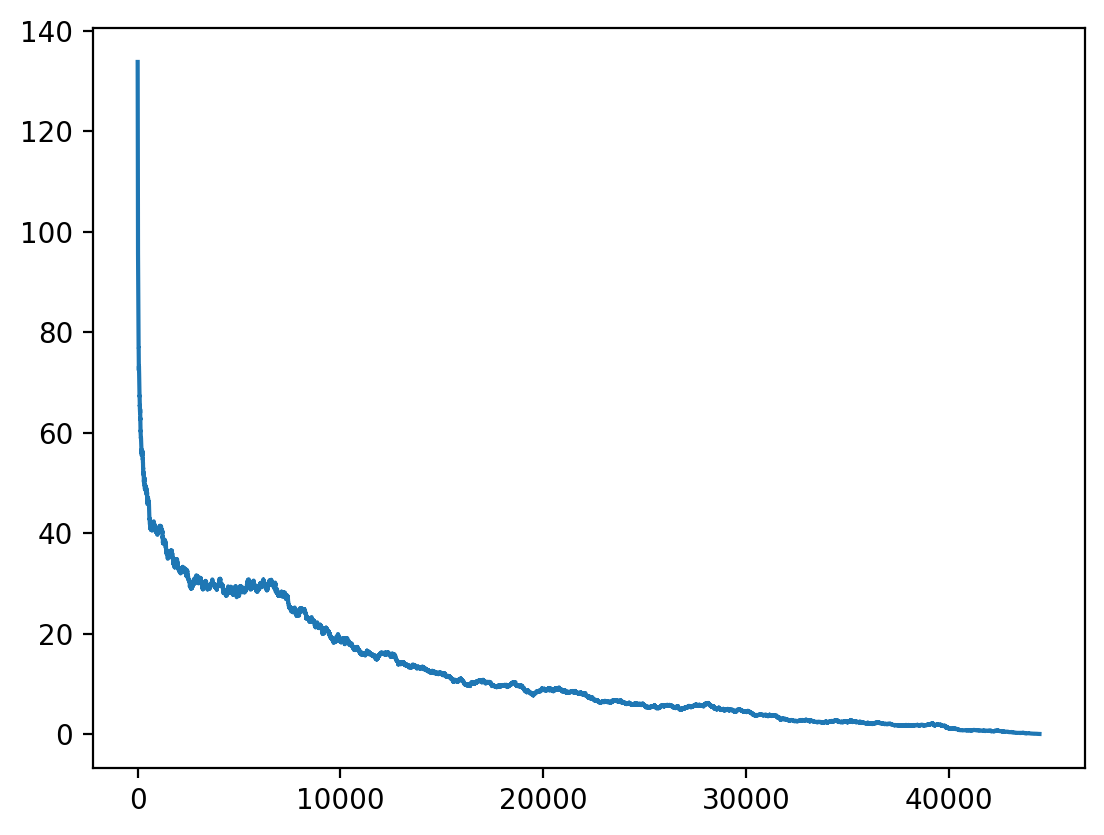

In [29]:
plt.plot(df['kldiv'])

In [3]:
expt = 'iter-bbb2'
srcdir = f'~/jobs/paper-{expt}/figs'
dstdir = f'~/bong/bong/results'
for suffix in ['pdf', 'png']:
    #src = f'{srcdir}/nlpd_smoothed_jitter_best_lr.{suffix}'
    src = f'{srcdir}/nlpd_smoothed_jitter_best_lr_250.{suffix}'
    #src = f'{srcdir}/nlpd_smoothed_jitter.{suffix}'
    dst = f'{dstdir}/{expt}-nlpd.{suffix}'
    cmd = f'cp {src} {dst}'
    print(cmd)
    os.system(cmd)

cp ~/jobs/paper-iter-bbb2/figs/nlpd_smoothed_jitter_best_lr_250.pdf ~/bong/bong/results/iter-bbb2-nlpd.pdf
cp ~/jobs/paper-iter-bbb2/figs/nlpd_smoothed_jitter_best_lr_250.png ~/bong/bong/results/iter-bbb2-nlpd.png


In [34]:
results_dir = '/teamspace/studios/this_studio/jobs/paper-algo-dlr-medium-n10k-lin-rank'

df = pd.read_csv(f'{results_dir}/jobs.csv')
df.head(n=20)

,jobname,algo,param,lin,dlr_rank,ef,nsample,niter,lr,model_str,key,dataset,data_dim,dgp_type,dgp_str,model_type,ntrain,ntest
0,paper-algo-dlr-medium-n10k-lin-rank-00,bong,diag,1,99,99,99,99,99.000,30_30_1,0,sarcos,0,na,na,mlp,10000,500
1,paper-algo-dlr-medium-n10k-lin-rank-01,bong,dlr,1,1,99,99,99,99.000,30_30_1,0,sarcos,0,na,na,mlp,10000,500
2,paper-algo-dlr-medium-n10k-lin-rank-02,bong,dlr,1,10,99,99,99,99.000,30_30_1,0,sarcos,0,na,na,mlp,10000,500
3,paper-algo-dlr-medium-n10k-lin-rank-03,bog,diag,1,99,99,99,99,0.005,30_30_1,0,sarcos,0,na,na,mlp,10000,500
4,paper-algo-dlr-medium-n10k-lin-rank-04,bog,diag,1,99,99,99,99,0.010,30_30_1,0,sarcos,0,na,na,mlp,10000,500
5,paper-algo-dlr-medium-n10k-lin-rank-05,bog,diag,1,99,99,99,99,0.050,30_30_1,0,sarcos,0,na,na,mlp,10000,500
6,paper-algo-dlr-medium-n10k-lin-rank-06,bog,diag,1,99,99,99,99,0.100,30_30_1,0,sarcos,0,na,na,mlp,10000,500
7,paper-algo-dlr-medium-n10k-lin-rank-07,bog,diag,1,99,99,99,99,0.500,30_30_1,0,sarcos,0,na,na,mlp,10000,500
8,paper-algo-dlr-medium-n10k-lin-rank-08,bog,dlr,1,1,99,99,99,0.005,30_30_1,0,sarcos,0,na,na,mlp,10000,500
9,paper-algo-dlr-medium-n10k-lin-rank-09,bog,dlr,1,10,99,99,99,0.005,30_30_1,0,sarcos,0,na,na,mlp,10000,500


In [ ]:
#condition = (df['minscore'] != df[args.metric])
condition = (df['lin']==1) | (df['ef']==0)
indices_to_drop = df[condition].index
df_filtered = df.drop(indices_to_drop)

df_filtered.head(n=20)

In [1]:
D = 22 # since add one for sarcos
# For FC
mlp = [(D+1)*n + (n+1)*1 for n in [10, 20, 30, 40]] # 1 layer
print(mlp)

# For DLR
mlp = [(D+1)*n + (n+1)*n  + (n+1)*1 for n in [10, 20, 30]] # 2 layer MLP
print(mlp)

mlp = [(D+1)*n + (n+1)*n + (n+1)*n + (n+1)*1 for n in [10, 20, 30]] # 3 layer MLP
print(mlp)


mlp=  (784+1)*50 + (50+1)*50  + (50+1)*10
print(mlp)



[241, 481, 721, 961]
[351, 901, 1651]
[461, 1321, 2581]
42310
